In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import pickle
import os
current_path = os.getcwd()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime, timedelta
import statistics
import time

import pymysql  
from haversine import haversine
from bisect import bisect_left, bisect_right

from geoband.API import *
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
import geoplot as gplt
import geoplot.crs as gcrs
import imageio
import mapclassify as mc

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
import pydeck as pdk
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import shapely
from shapely import wkt
from shapely.geometry import Polygon, Point, shape

# NLP 
import re
from konlpy.tag import Okt

!pip install glove_python
from glove import Corpus, Glove

# Crawling 
import requests
from bs4 import BeautifulSoup

# Clustering 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn import metrics
from scipy.spatial.distance import cdist

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'

Using Python-MIP package version 1.5.3


In [2]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

# 1. Data Merge

In [28]:
df01 = df_01[["정류장ID", "정류장명", "lon", "lat"]].rename(columns={'정류장ID' : '정류소ID'})
print(df01.shape)
df01.head(2)

(1179, 4)


,정류소ID,정류장명,lon,lat
0,201000313,권선구청,126.970983,37.256983
1,201000344,중보들공원,126.991029,37.244605


In [29]:
df_02_06 = pd.concat([df_02, df_03, df_04, df_05, df_06], axis=0, ignore_index = True)

# 노선번호 object 형태로 맞춰주기 
df_02_06["노선번호"] = df_02_06["노선번호"].progress_apply(lambda x : str(x))

# '92' 처럼 용남고속 & 수원여객 동시운행 버스 통합  
df_02_06 = df_02_06.groupby(by=['일자', '정류소ID', '노선번호', '노선유형']).sum([['전체승차건수','초승건수','환승건수','전체하차건수','하차건수','미태그건수']]).reset_index()
df_02_06 = df_02_06.drop(['하차 건수','미태그 건수'], axis=1)

# 기존 버스 데이터에 합치기 
df01 = df_02_06.merge(df01, how='left', on = '정류소ID', copy = True)

100%|██████████| 2508607/2508607 [00:03<00:00, 745600.96it/s]


In [30]:
df01 = df01.drop_duplicates(["정류소ID", "노선번호", "정류장명", "lon", "lat"]).drop(['일자', '노선유형', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수'], axis=1)
print('unique 한 노선 개수 : ', df01.노선번호.nunique())
print(df01.shape)
df01.head()

unique 한 노선 개수 :  156
(7655, 5)


,정류소ID,노선번호,정류장명,lon,lat
0,200000001,13,하광교느티나무,127.016928,37.317630
1,200000002,13,하광교,127.019208,37.315958
2,200000004,13,문암골,127.027748,37.309108
3,200000005,13,광교산입구.경기대수원캠퍼스,127.031546,37.301462
4,200000006,13,광교공원.경기대수원캠퍼스입구.연무시장,127.029464,37.300014


In [14]:
route = pd.read_excel(current_path+'/data/GGD_RouteInfo_M.xls')
trans = pd.read_excel(current_path+'/data/GGD_RouteStationInfo_M.xls', sheet_name=[0,1,2])

trans = pd.concat([trans[0], trans[1], trans[2]], axis=0, ignore_index = True)

In [15]:
# 버스 노선 순서 데이터 
trans2 = trans.rename(columns = {"STATION_ID": "정류소ID", "ROUTE_ID": "노선ID", "ROUTE_NM": "노선번호", "STA_ORDER": "노선순서", "STATION_NM": "정류장명"})
trans2 = trans2.drop(["순번", "MOBILE_NO"], axis=1)

# 노선 번호 전처리 
tqdm.pandas()
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : str(x))
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : x.replace("-", "_"))

100%|██████████| 192708/192708 [00:00<00:00, 686696.35it/s]


In [37]:
# Data Merge 
tmp2 = df01.merge(trans2.drop(["정류장명"], axis=1), how='left', on=['정류소ID', '노선번호'])
tmp2 = tmp2.dropna(axis=0)

print("bus+trans shape : ", tmp2.shape , '\n') 
print("원래 데이터의 unique 노선 개수 : ", df01.노선번호.nunique())
print("합친 데이터의 unique 노선 개수 : ", tmp2.노선번호.nunique())
print("=====" * 20)
tmp2.head(2)

bus+trans shape :  (7189, 7) 

원래 데이터의 unique 노선 개수 :  156
합친 데이터의 unique 노선 개수 :  156


,정류소ID,노선번호,정류장명,lon,lat,노선ID,노선순서
0,200000001,13,하광교느티나무,127.016928,37.317630,200000037.000000,74.000000
1,200000002,13,하광교,127.019208,37.315958,200000037.000000,73.000000


# 2. Distance 

In [173]:
def dist_df(df, busnum) : 
    dataframe = df[df["노선번호"] == busnum].sort_values('노선순서').reset_index(drop=True)
    numlist = list(dataframe["노선순서"]) 
    
    
    # index 순서대로 정렬하고, 순서가 jump 되어 있는 dataframe 나누기 
    splitlist = [] 
    for i in range(len(numlist)-1) : 
        if numlist[i+1] - numlist[i] > 1 : 
            splitlist.append(i)

    splitdict = dict() 
    if len(splitlist) != 0 :                
        for idx, sp in enumerate(splitlist) : 
            if idx == 0 : 
                splitdict[idx] = dataframe[:sp+1]
            else : 
                splitdict[idx] = dataframe[(splitlist[idx - 1])+1:sp+1]
        splitdict[len(splitlist)] = dataframe[splitlist[-1]+1:]
        
    else : 
        splitdict[0] = dataframe

    
    # 나누어진 dataframe 중 len > 1 인 것만 거리 체크하기 
    finaldf = dict() 
    for key, splitdf in splitdict.items() :  
        if len(splitdf) > 1 : 
            
            splitdf["nextlon"] , splitdf["nextlat"] = 0.1, 0.1 
            for j in range(len(splitdf)-1) : 
                splitdf["nextlon"].iloc[j] , splitdf["nextlat"].iloc[j] = splitdf["lon"].iloc[j+1] , splitdf["lat"].iloc[j+1] 
                
            splitdf["meter"] = splitdf.apply(lambda x : haversine((x['lon'], x['lat']), (x['nextlon'], x['nextlat']), unit = 'm'), axis=1)
            finaldf[key] = splitdf[:-1]
            
    # 평균거리 구하기 
    mean = np.mean([df["meter"].mean() for df in finaldf.values()])
    
    return mean

In [174]:
for num in tmp2.노선번호.unique() : 
    print(dist_df(tmp2, num))

375.90183308982455
393.69781618809304
343.84247549569676
314.8611337017368
391.1408905327435
382.6813269132959
304.8850059733164
304.8850059733164
304.8850059733164
363.2809262935003
507.0461377315452
308.20714046114847
374.08925133486986
351.894835712385
326.36360654270266
354.02758266628564
382.32576695701323
305.5197518547227
345.2473774244128
371.64479698124535
340.4440425122131
408.1052053255449
386.6829960142135
336.2133647409478
450.8845026236792
340.38512491770416
337.55232581497626
536.2124120333742
419.60374213568184
322.28228255406935
391.03794020940666
386.1365195716829
390.7016171179577
391.03794020940666
150.59175049262572
197.52735911282554
375.9568965977902
441.0956563073143
447.1680330304979
352.1008665099073
410.512728470919
451.3242812311102
371.26282973724915
390.49084970368244
355.5532749188404
409.63939696164095
400.27309063047903
335.56865289218763
335.56865289218763
315.64899050996524
330.88169513488754
351.1590302175538
405.71776041770613
358.1091104711345
456.

In [211]:
mean_values = [dist_df(tmp2, num) for num in tmp2.노선번호.unique() if dist_df(tmp2, num) > 100]

In [212]:
np.mean(mean_values)

457.6914467655099

<AxesSubplot:ylabel='Density'>

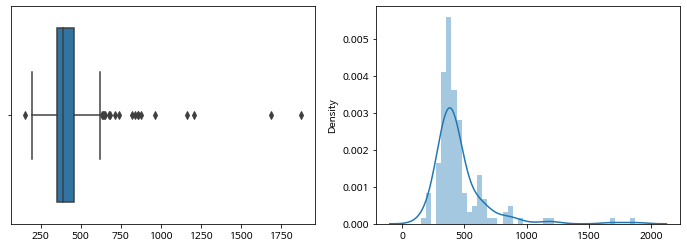

In [213]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(mean_values, ax=ax1)
sns.distplot(mean_values, ax=ax2)

In [214]:
pd.DataFrame(mean_values).describe()

,0
count,148.000000
mean,457.691447
std,225.178756
min,150.591750
25%,351.710884
50%,393.107670
75%,460.451513
max,1872.878079
